In [2]:
!pip install --upgrade PyDOE

  Created wheel for PyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=17618bad072dcb8bc43d5f155a28968b667818f3c611e6489dfb21ba299966e6
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built PyDOE


In [3]:
import jax.numpy as np
import numpy as onp
from jax import vmap, jit, vjp, random
from jax.scipy.linalg import cholesky, solve_triangular

from jax.config import config
config.update("jax_enable_x64", True)

from pyDOE import lhs
from functools import partial
from tqdm import trange
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rc

onp.random.seed(1234)

In [4]:
# A vectorized RBF kernel function
def RBF(x1, x2, params):
    output_scale = params[0]
    lengthscales = params[1:]
    diffs = np.expand_dims(x1 / lengthscales, 1) - \
            np.expand_dims(x2 / lengthscales, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)

In [5]:
# A wrapper to call SciPy's L-BFGS-B optimizer
def minimize_lbfgs(objective, x0, bnds = None):
    result = minimize(objective, x0, jac=True,
                      method='L-BFGS-B', bounds = bnds,
                      callback=None)
    return result.x, result.fun

In [6]:
# A minimal Gaussian process class
class GPRegression:
    # Initialize the class
    def __init__(self, kernel_fn = RBF): 
        self.kernel = kernel_fn
                              
    def random_init_GP(self, rng_key, dim):
        logsigma_f = np.log(50.0*random.uniform(rng_key, (1,)))
        loglength  = np.log(random.uniform(rng_key, (dim,)) + 1e-8)
        logsigma_n = np.array([-4.0]) + random.normal(rng_key, (1,))
        hyp = np.concatenate([logsigma_f, loglength, logsigma_n])
        return hyp

    def compute_cholesky(self, params, batch):
        X, _ = batch
        N, D = X.shape
        # Fetch params
        sigma_n = np.exp(params[-1])
        theta = np.exp(params[:-1])
        # Compute kernel
        K = self.kernel(X, X, theta) + np.eye(N)*(sigma_n + 1e-8)
        L = cholesky(K, lower=True)
        return L

    def likelihood(self, params, batch):
        _, y = batch
        N = y.shape[0]
        # Compute Cholesky
        L = self.compute_cholesky(params, batch)
        # Compute negative log-marginal likelihood
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        NLML = 0.5*np.matmul(np.transpose(y),alpha) + \
               np.sum(np.log(np.diag(L))) + 0.5*N*np.log(2.0*np.pi)
        return NLML

    @partial(jit, static_argnums=(0,))
    def likelihood_value_and_grad(self, params, batch):
        fun = lambda params: self.likelihood(params, batch)
        primals, f_vjp = vjp(fun, params)
        grads = f_vjp(np.ones_like(primals))[0]
        return primals, grads

    def train(self, batch, rng_key, num_restarts = 10):
        # Define objective that returns NumPy arrays (to be minimized with SciPy)
        def objective(params):
            value, grads = self.likelihood_value_and_grad(params, batch)
            out = (onp.array(value), onp.array(grads))
            return out
        # Optimize with random restarts
        params = []
        likelihood = []
        X, _ = batch
        dim = X.shape[1]
        rng_key = random.split(rng_key, num_restarts)
        for i in trange(num_restarts):
            init = self.random_init_GP(rng_key[i], dim)
            p, val = minimize_lbfgs(objective, init)
            params.append(p)
            likelihood.append(val)
        params = np.vstack(params)
        likelihood = np.vstack(likelihood)
        #### find the best likelihood (excluding any NaNs) ####
        bestlikelihood = np.nanmin(likelihood)
        idx_best = np.where(likelihood == bestlikelihood)
        idx_best = idx_best[0][0]
        best_params = params[idx_best,:]
        return best_params

    @partial(jit, static_argnums=(0,))
    def predict(self, params, batch, X_star):
        X, y = batch
        # Fetch params
        sigma_n = np.exp(params[-1])
        theta = np.exp(params[:-1])
        # Compute kernels
        k_pp = self.kernel(X_star, X_star, theta) + np.eye(X_star.shape[0])*(sigma_n + 1e-8)
        k_pX = self.kernel(X_star, X, theta)
        L = self.compute_cholesky(params, batch)
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        beta  = solve_triangular(L.T,solve_triangular(L, k_pX.T, lower=True))
        # Compute predictive mean, std
        mu = np.matmul(k_pX, alpha)
        cov = k_pp - np.matmul(k_pX, beta)
        std = np.sqrt(np.clip(np.diag(cov), a_min=0.))
        return mu, std

    @partial(jit, static_argnums=(0))
    def draw_posterior_samples(self, rng_key, params, batch, X_star):
        X, y = batch
        N, D = X.shape
        N_star = X_star.shape[0]
        # Fetch params
        sigma_n = np.exp(params[-1])
        theta = np.exp(params[:-1])
        # Compute kernels
        k_pp = self.kernel(X_star, X_star, theta) + sigma_n*np.eye(N_star)
        k_pX = self.kernel(X_star, X, theta)
        L = self.compute_cholesky(params, batch)
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        beta  = solve_triangular(L.T,solve_triangular(L, k_pX.T, lower=True))
        # Compute predictive mean and covariance
        mu = np.matmul(k_pX, alpha)
        cov = k_pp - np.matmul(k_pX, beta)
        # Generate samples via the reparemetrization trick
        num_samples = 100
        L = cholesky(cov + 1e-8*np.eye(N_star), lower=True)
        mu = np.tile(mu[:, np.newaxis], (1,num_samples))
        samples = mu + np.dot(L, random.normal(rng_key, (N_star, num_samples)))
        return samples    

    def acquisition(self, params, batch, x):
        x = x[None,:]
        mean, std = self.predict(params, batch, x)
        return -mean[0] + 2.0*std[0]

    @partial(jit, static_argnums=(0,))
    def acq_value_and_grad(self, params, batch, x):
        fun = lambda x: self.acquisition(params, batch, x)
        primals, f_vjp = vjp(fun, x)
        grads = f_vjp(np.ones_like(primals))[0]
        return primals, grads

    def next_best_point(self, params, batch, bounds, rng_key, num_restarts = 30):
        # Define objective that returns NumPy arrays
        def objective(x):
            x = (x - lb)/(ub-lb)
            value, grads = self.acq_value_and_grad(params, batch, x)
            out = (onp.array(value), onp.array(grads))
            return out
        # Optimize with random restarts
        loc = []
        acq = []
        lb, ub = bounds
        dim = lb.shape[0]
        onp.random.seed(rng_key[0])
        x0 = lb + (ub-lb)*lhs(dim, num_restarts)
        dom_bounds = tuple(map(tuple, np.vstack((lb, ub)).T))
        for i in trange(num_restarts):
            pos, val = minimize_lbfgs(objective, x0[i,:], bnds = dom_bounds)
            loc.append(pos)
            acq.append(val)
        loc = np.vstack(loc)
        acq = np.vstack(acq)
        idx_best = np.argmin(acq)
        x_new = loc[idx_best:idx_best+1,:]
        return x_new

In [7]:
# Define bounds for test data
dim = 3
lb = np.array([10, 10, 600])
ub = np.array([55, 25, 3000])
bounds= lb, ub


# Problem settings
N = 15
noise = 0.0

# Initial training data
X=onp.array([[10,20,3000],[10,25,1000],[10,10,600],[10,15,2000],[25,20,600],[25,15,1000],[25, 10, 3000],[25, 25, 2000],[40, 10, 1000],[40, 20, 2000],[40, 25, 600],[40, 15, 3000],[55, 10, 2000],[55, 15, 600], [55, 20 ,1000]])
y = onp.array([.05, 3.24, .016, .0004, 7.14, 3.22, .00033, 7.21, 1.85, 6.16, 3.90, 2.27, 1.16, 3.18, 3.89])

# Test data
nn = 20
xx_10= 10* onp.ones((400,1))
xx_25= 25* onp.ones((400,1))
xx_40= 40* onp.ones((400,1))
xx_55= 55* onp.ones((400,1))
yy = np.linspace(lb[1], ub[1], nn)
zz = np.linspace(lb[2], ub[2], nn)
YY, ZZ =  np.meshgrid(yy, zz)
X_star_10= np.concatenate([xx_10, np.concatenate([YY.flatten()[:,None], ZZ.flatten()[:,None]], axis = 1)] ,axis=1)
X_star_25= np.concatenate([xx_25, np.concatenate([YY.flatten()[:,None], ZZ.flatten()[:,None]], axis = 1)] ,axis=1)
X_star_40= np.concatenate([xx_40, np.concatenate([YY.flatten()[:,None], ZZ.flatten()[:,None]], axis = 1)] ,axis=1)
X_star_55= np.concatenate([xx_55, np.concatenate([YY.flatten()[:,None], ZZ.flatten()[:,None]], axis = 1)] ,axis=1)
#y_star = vmap(f)(X_star)

# Normalized test inputs
X_test_10= (X_star_10 - lb)/(ub-lb)
X_test_25= (X_star_25- lb)/(ub-lb)
X_test_40= (X_star_40- lb)/(ub-lb)
X_test_55= (X_star_55- lb)/(ub-lb)

In [8]:
model = GPRegression(kernel_fn = RBF)

In [9]:
# Normalize training data
mu_y, sigma_y = y.mean(0), y.std(0)
X_train = (X - lb)/(ub-lb)
y_train = (y - mu_y)/sigma_y

# Train model
print('\nTrain GP...')
train_key = random.PRNGKey(0)
opt_params = model.train((X_train, y_train), train_key, num_restarts = 50)



Train GP...


100%|██████████| 50/50 [00:01<00:00, 32.83it/s]


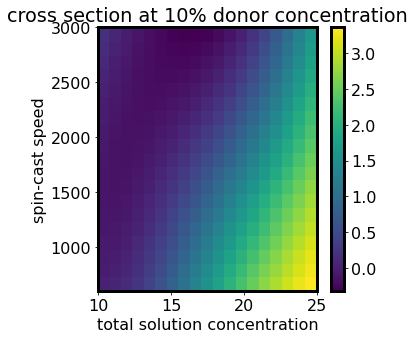

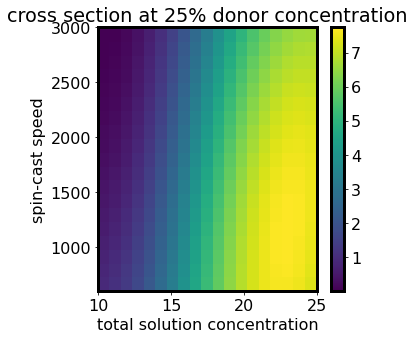

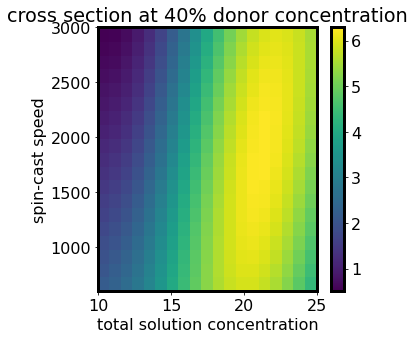

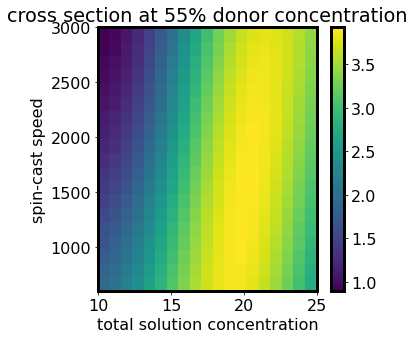

In [10]:
# Plot
mean, std = model.predict(opt_params, (X_train, y_train), X_test_10)
mean, std = mean*sigma_y + mu_y, std*sigma_y      # De-normalize predictions

plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.linewidth']=3

plt.figure(figsize = (25,5))
plt.subplot(1,5,1)

plt.pcolor(YY, ZZ, mean.reshape(nn,nn))
plt.colorbar()
plt.xlabel('total solution concentration')
plt.ylabel('spin-cast speed')
plt.title('cross section at 10% donor concentration')
plt.tight_layout()


# Plot
mean, std = model.predict(opt_params, (X_train, y_train), X_test_25)
mean, std = mean*sigma_y + mu_y, std*sigma_y      # De-normalize predictions

plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.linewidth']=3

plt.figure(figsize = (25,5))
plt.subplot(1,5,1)

plt.pcolor(YY, ZZ, mean.reshape(nn,nn))
plt.colorbar()
plt.xlabel('total solution concentration')
plt.ylabel('spin-cast speed')
plt.title('cross section at 25% donor concentration')
plt.tight_layout()


# Plot
mean, std = model.predict(opt_params, (X_train, y_train), X_test_40)
mean, std = mean*sigma_y + mu_y, std*sigma_y      # De-normalize predictions

plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.linewidth']=3

plt.figure(figsize = (25,5))
plt.subplot(1,5,1)

plt.pcolor(YY, ZZ, mean.reshape(nn,nn))
plt.colorbar()
plt.xlabel('total solution concentration')
plt.ylabel('spin-cast speed')
plt.title('cross section at 40% donor concentration')
plt.tight_layout()

# Plot
mean, std = model.predict(opt_params, (X_train, y_train), X_test_55)
mean, std = mean*sigma_y + mu_y, std*sigma_y      # De-normalize predictions

plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.linewidth']=3

plt.figure(figsize = (25,5))
plt.subplot(1,5,1)

plt.pcolor(YY, ZZ, mean.reshape(nn,nn))
plt.colorbar()
plt.xlabel('total solution concentration')
plt.ylabel('spin-cast speed')
plt.title('cross section at 55% donor concentration')
plt.tight_layout()

In [11]:
#Alteration of test points after second round of experiments
# Define test function
dim = 3
lb = np.array([10, 10, 600])
ub = np.array([55, 25, 3000])
bounds= lb, ub


# Problem settings
N = 28
noise = 0.0
X=onp.array([[10,20,3000],[10,25,1000],[10,10,600],[10,15,2000],[25,20,600],[25,15,1000],[25, 10, 3000],[25, 25, 2000],[40, 10, 1000],[40, 20, 2000],[40, 25, 600],[40, 15, 3000],[55, 10, 2000],[55, 15, 600], [55, 20 ,1000], [20,20,1500],[27,20,1500],[20,25,1500],[27,25,1500],[20,23,1000],[27,23,1000],[20,23,2000],[27,23, 200],[25, 20, 1000],[25, 25, 1000],[25, 20, 2000],[25, 25, 2000], [25, 23, 1500]])
y = onp.array([.05, 3.24, .016, .0004, 7.14, 3.22, .00033, 7.21, 1.85, 6.16, 3.90, 2.27, 1.16, 3.18, 3.89, 6.32, 7.21, 6.83, 6.96, 7.77, 6.87, 6.43, 7.65, 7.43, 6.88, 7.32, 7.21, 7.4])

# Test data
nn = 20
xx_20= 20* onp.ones((400,1))
xx_25= 25* onp.ones((400,1))
xx_27= 27* onp.ones((400,1))
yy = np.linspace(lb[1], ub[1], nn)
zz = np.linspace(800, 2200, nn)
YY, ZZ =  np.meshgrid(yy, zz)
X_star_20= np.concatenate([xx_10, np.concatenate([YY.flatten()[:,None], ZZ.flatten()[:,None]], axis = 1)] ,axis=1)
X_star_25= np.concatenate([xx_25, np.concatenate([YY.flatten()[:,None], ZZ.flatten()[:,None]], axis = 1)] ,axis=1)
X_star_27= np.concatenate([xx_40, np.concatenate([YY.flatten()[:,None], ZZ.flatten()[:,None]], axis = 1)] ,axis=1)
#y_star = vmap(f)(X_star)

# Normalized test inputs
X_test_20= (X_star_20 - lb)/(ub-lb)
X_test_25= (X_star_25- lb)/(ub-lb)
X_test_27= (X_star_40- lb)/(ub-lb)

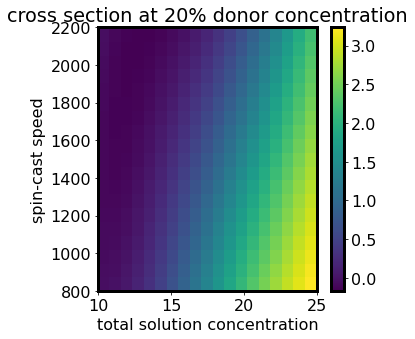

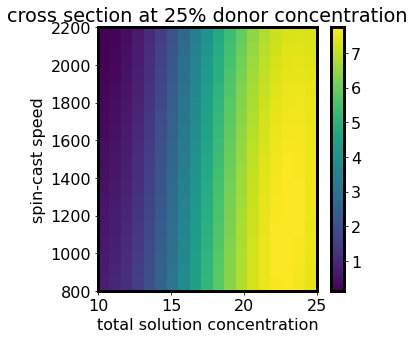

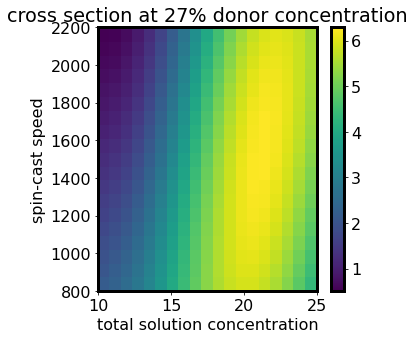

In [12]:
# Plot
mean, std = model.predict(opt_params, (X_train, y_train), X_test_20)
mean, std = mean*sigma_y + mu_y, std*sigma_y      # De-normalize predictions

plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.linewidth']=3

plt.figure(figsize = (25,5))
plt.subplot(1,5,1)

plt.pcolor(YY, ZZ, mean.reshape(nn,nn))
plt.colorbar()
plt.xlabel('total solution concentration')
plt.ylabel('spin-cast speed')
plt.title('cross section at 20% donor concentration')
plt.tight_layout()

# Plot
mean, std = model.predict(opt_params, (X_train, y_train), X_test_25)
mean, std = mean*sigma_y + mu_y, std*sigma_y      # De-normalize predictions

plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.linewidth']=3

plt.figure(figsize = (25,5))
plt.subplot(1,5,1)

plt.pcolor(YY, ZZ, mean.reshape(nn,nn))
plt.colorbar()
plt.xlabel('total solution concentration')
plt.ylabel('spin-cast speed')
plt.title('cross section at 25% donor concentration')
plt.tight_layout()

# Plot
mean, std = model.predict(opt_params, (X_train, y_train), X_test_27)
mean, std = mean*sigma_y + mu_y, std*sigma_y      # De-normalize predictions

plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.linewidth']=3

plt.figure(figsize = (25,5))
plt.subplot(1,5,1)

plt.pcolor(YY, ZZ, mean.reshape(nn,nn))
plt.colorbar()
plt.xlabel('total solution concentration')
plt.ylabel('spin-cast speed')
plt.title('cross section at 27% donor concentration')
plt.tight_layout()